# Analyse des résultats du premier tour des élections présidentielles au Niger

**Grégoire Lurton** [@grlurton](https://twitter.com/grlurton)

Le premier tour des élections présidentielles 2016 au Niger a eu lieu le 21 février 2016. Il a opposé 15 candidats, dont deux se sont qualifiés pour un second tour qui aura lieu le 20 mars. La Commission Electorale Nationale Indépendante était chargée d'organiser ces élections, et a publié un nombre exeptionnel de données sur son site internet : http://www.ceni-niger.org/. Cette transparence inédite doit être remarquée, et il m'est apparu intéressant d'en profiter pour proposer une présentation des résultats de ce premier tour.

J'ai donc extrait toutes les données qui me paraissaient intéressantes dans ce site et en présente ici une première analyse. L'analyse est présentée sous la forme d'un *Jupyter Notebook* qui est une solution simple pour présenter des résultats d'une analyse en cours. Pour faciliter la lecture j'ai essayé de nettoyer au maximum le code pour renvoyer dans des scripts annexes les lignes qui ne contribuent pas directement aux résultats de l'analyse elle même. Tous ces scripts ainsi que les scripts utilisés pour l'extraction des données sont disponible sur https://github.com/grlurton/niger_election. Je tiens les données que j'utilise à la disposition de toute personne intéressée qui voudrait reproduire ces analyses ou les approfondir.

Je suis preneur de feedback et de suggestions d'analyses complémentaires.

# Ouverture des données

On commence par charger les librairies qu'on utilisera par la suite.

In [5]:
import pandas as pd
import os as os
import numpy as np
import matplotlib.pyplot as plt
from ggplot import *
import json
from io import StringIO

from collections import OrderedDict
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool 
from bokeh.models.widgets.layouts import VBox,HBox
from bokeh.models.widgets import Dropdown
from bokeh.io import vform

%matplotlib inline  

os.chdir('c://users/grlurton/Google Drive/elections_niger')

Les données disponibles sur le site de la CENI sont de trois sortes :
1. [Les listes électorales](http://www.ceni-niger.org/ceniProject/electeurs/bureau) sont disponibles par bureau de vote. 
2. [Les résultats du premier tour](http://www.ceni-niger.org/ceniProject/regions/map) sont disponibles par communes
3. Le découpage administratif du territoire utilisé par la CENI peut être lu à travers les cartes des résultats, jusqu'au niveau départemental. J'ai utilisé ces données pour simplifier le matching des autres données avec les données cartographiques. Elles souffrent toutefois de quelques petites inconsistances qu'il faudrait que je corrige à la main et à l'heure actuelle un ou deux départements manquent sur les cartes.

L'extraction des listes électorales se fait à travers [un script qui lit l'intégralité des bureaux de vote](https://github.com/grlurton/niger_election/blob/master/Extraction%20Listes%20Electorales.ipynb), [un script qui lit les listes électorales](https://github.com/grlurton/niger_election/blob/master/Extraction%20Electeurs.ipynb) et les anonymises, et [un script qui met en forme toutes ces données](https://github.com/grlurton/niger_election/blob/master/Extraction%20Electeurs.ipynb).

L'extraction des résultats se fait [en un seul script](https://github.com/grlurton/niger_election/blob/master/Extraction%20Resultats.ipynb) qui extrait les résultats aux niveaux régionaux, départementaux et communaux. L'extraction a l'air d'avoir buggé pour plusieurs bureaux, mais je pense que c'est assez marginal (TODO : regarder la complétude de plus près).

L'extraction des données cartographiques se fait en [un script](https://github.com/grlurton/niger_election/blob/master/Extraction%20Carto.ipynb) qui exporte ces données au format json.

A ce stade, on se contente de lire ces données.

In [3]:
## Données électeurs
store_electeurs = pd.HDFStore('data/full_data.h5')
data_electeurs = store_electeurs['complete_data']
store_electeurs.close()

## Données carto
with open('data/dept_map.json') as json_data:
    carto_dept = json.load(json_data)
    json_data.close()
    
with open('data/reg_map.json') as json_data:
    carto_reg = json.load(json_data)
    json_data.close()
    
store_resultats = pd.HDFStore('data/data_resultats.h5')
resultats_regions = store_resultats['data_regions']
resultats_departements = store_resultats['data_departements']
resultats_communes = store_resultats['data_communes']
store_resultats.close()

In [4]:
#### Renvoyer ça dans le script de formatage
data_electeurs['age'] = pd.datetime(2016, 2 , 21) - data_electeurs['date_de_naissance']
data_electeurs['age'] = data_electeurs['age'].astype('timedelta64[D]') / 365.25

# Description du Corps Electoral

Un premier axe d'analyse intéressant de ces données est de décrire le corps électoral nigérien. Plus de 7.5 millions de nigériens sont inscrits sur les listes électorales ce qui donne une fenêtre unique sur cette population et sa distribution. 

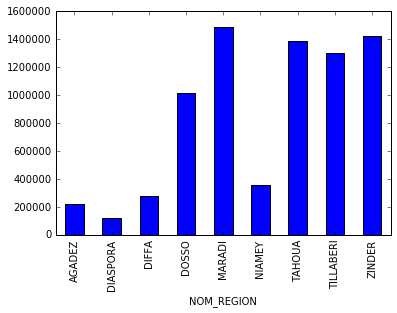

In [6]:
region_date = data_electeurs['NOM_REGION'].groupby(data_electeurs['NOM_REGION']).apply(len)
region_date.plot(kind = 'bar')

Trois axes d'analyse me paraissent intéressants à explorer: 
1. Description du corps électoral à travers les variables disponibles (essentiellement âge)
2. Comparaison du corps électoral aux données du recensement de 2012
3. Comparaison des listes électorales avec les dénominateurs des résultats du vote

In [7]:
resultats_regions['ID'] = resultats_regions['ID'].str.replace('Region de :' , '')

In [8]:
inscrits_dept = data_electeurs['NOM_DEPART'].groupby([data_electeurs['NOM_DEPART'] , data_electeurs['NOM_REGION']]).apply(len)

In [ ]:
u = pd.merge(inscrits_dept.reset_index(), resultats_regions , left_on = 'NOM_DEPART' , right_on = 'Département')
a = u.columns.tolist()
a[2] = 'n_electeurs'
u.columns = a

In [ ]:
u['Inscrits'] = u['Inscrits'].str.replace(' ', '').astype(int)
u['Inscrits ayant voté'] = u['Inscrits ayant voté'].str.replace(' ', '').astype(int)

In [ ]:
ggplot(aes(x='n_electeurs', y='Inscrits', colour = 'ID'), data=u ) +  geom_point() +  \
 ylim(low = 0 , high = 400000)+ xlim(low = 0 , high = 400000)

In [ ]:
ggplot(aes(x='Inscrits', y='Inscrits ayant voté' , colour = 'ID'), data=u ) +  \
geom_point() + ylim(low = 0 , high = 200000)+ xlim(low = 0 , high = 400000)

In [ ]:
u['Votants sur liste additive'] = u['Bulletins blancs ou nuls'].str.replace(' ', '').astype(int)

In [ ]:
ggplot(aes(x='Bulletins blancs ou nuls', y='Votants sur liste additive' , colour = 'ID'), data=u ) +  \
geom_point() + ylim(low = 0 , high = 15000)+ xlim(low = 0 , high = 25000)

In [ ]:
u['Nbre total de votants'] = u['Nbre total de votants'].str.replace(' ', '').astype(int)
u['prop_additifs'] = u['Votants sur liste additive'] / u['Nbre total de votants']

In [ ]:
qplot(u['prop_additifs'])

# Cartographie des résultats

In [ ]:
candidats = ['Laouan Magagi', 'Mahaman Jean Philipe Padonou', 'Abdou Labo', 'Kassoum M. Moctar', 'Adal Rhoubeid', 
             'Mahamane Ousmane', 'Seyni Omar', 'Tahirou Guimba', 'Hama Amadou', 'Ibrahim Yacouba', 'Mahaman Hamissou Maman',
             'Mahamadou Issoufou', 'Dr. Abdoulaye Amadou Traoré', 'Cheffou Amadou','Boubacar Cissé']

listes = ['Inscrits', 'Inscrits ayant voté', 'Votants sur liste additive', 'Nbre total de votants', 'Bulletins blancs ou nuls',
          'Suffrages exprimés valables']


colors = [['#f7fcfd','#e5f5f9','#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b'] , 
          ['#f7f4f9','#e7e1ef','#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#980043','#67001f'] ,
          ['#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506'] ,
          ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#a50f15','#67000d'] ,
          ['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d'] ,
          ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b'] ,
          ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858'] ,
          ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'] ,
          ['#ffffff','#f0f0f0','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525','#000000'] ,
          ['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c','#f16913','#d94801','#a63603','#7f2704'] ,
          ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'] ,
          ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b'] ,
          ['#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'] ,
          ['#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506'] ,
          ['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'] ]
          

for col in listes :
    u[col] = u[col].str.replace(' ', '').astype(int)

for col in candidats :
    u[col] = u[col].str.replace(' ', '').astype(int)
    prop_candidat = 'prop_' + col
    u[prop_candidat] = u[col] / u['Nbre total de votants']

In [ ]:
def create_binning(data , variable , n_colors , index) :
    data = data.reset_index()
    bins = np.linspace(data[variable].min(), data[variable].max(), n_colors)
    data['bin'] = np.digitize(data[variable], bins) - 1
    out = data.set_index(index)
    return out

In [ ]:
def temporaire_dept_mapping(data , variable , index , colormap):
    n_colors = len(colormap)
    binned_data = create_binning(data , variable , n_colors , index)
    regions_names = []
    regions_ID = []
    xs = []
    ys = []
    values = []
    cols = []
    for i in carto_dept.keys() :
        x = []
        y = []
        reg_sel = carto_dept[i]
        name = reg_sel['name']
        ID = reg_sel['id_zone']
        x = reg_sel['x']
        y = reg_sel['y']
        if (pd.isnull(name) == False) & (name != 590) & (name not in ['TAHOUA' , 'TAGAZAR'])  :
            val = binned_data[variable][name] * 100
            col = colormap[binned_data['bin'][name].astype(int)]
            values.append(val)
            regions_names.append(name)
            regions_ID.append(ID)
            xs.append(x)
            ys.append(y)
            cols.append(col)
            
    map_source = ColumnDataSource(
        data = dict(
            x=xs,
            y=ys,
            ID=regions_ID,
            name=regions_names ,
            value = values ,
            colors = cols
        )
    )
    return map_source 

In [ ]:
from bokeh.plotting import figure, gridplot , output_notebook, show , output_file
from bokeh.palettes import YlOrRd9
YlOrRd9.reverse()

output_notebook()

graphs = {} 

for i in range(len(candidats)) :
    candidat = candidats[i]
    
    col1 = YlOrRd9
    
    prop_candidat = 'prop_' + candidat
    source_rate = temporaire_dept_mapping(u , prop_candidat ,  'Département' , col1)


    p = figure(plot_width=300, plot_height=300,
                title=candidat , title_text_font_size='8pt')
    p.patches('x', 'y',
                fill_color='colors' ,
                line_color="grey", line_width=0.5,
                source=source_rate)
        
    
    hover = p.select(dict(type=HoverTool))
    hover.point_policy = "follow_mouse"
    hover.tooltips = OrderedDict([
            ("Nom", "@name"),
            ("% des suffrages reçus", "@value %")  
        ])    
    graphs[candidat] = p

    
    
dictlist = []
liste_complete = []
i = 0
for key in graphs.keys():
    i = i+1
    dictlist.append(graphs[key])
    if i == 3 :
        liste_complete.append(dictlist)
        dictlist = []
        i = 0
    

p_fin = gridplot(liste_complete, toolbar_location=None)
show(p_fin)

In [ ]:
# Age Median
region_date = data_electeurs['age'].groupby(data_electeurs['ID_REGION']).median()
num_colors = 5
bins = np.linspace(region_date.min(), region_date.max(), num_colors)
region_date = region_date.reset_index()
region_date['bin'] = np.digitize(region_date['age'], bins) - 1
region_date.sort_values('bin', ascending=False)
region_date = region_date.set_index('ID_REGION')

In [ ]:
colors = ["#edf8fb","#b2e2e2","#66c2a4",'#2ca25f',"#006d2c"]
regions_names = []
regions_ID = []
xs = []
ys = []
values = []
cols = []
for i in carto_reg.keys() :
    x = []
    y = []
    reg_sel = carto_reg[i]
    name = reg_sel['name']
    ID = reg_sel['id_zone']
    x = reg_sel['x']
    y = reg_sel['y']

    if (pd.isnull(ID) == False) & (ID != 590) :
        val = region_date['age'][ID]
        col = colors[region_date['bin'][ID].astype(int)]
        values.append(val)
        regions_names.append(name)
        regions_ID.append(ID)
        xs.append(x)
        ys.append(y)
        cols.append(col)
    
source_rate = ColumnDataSource(
    data = dict(
        x=xs,
        y=ys,
        ID=regions_ID,
        name=regions_names ,
        value = values ,
        colors = cols
    )
)

In [ ]:
output_notebook()

TOOLS="pan,wheel_zoom,reset,hover"

p = figure(plot_width=700, plot_height=700,
           tools=TOOLS, title="Age Médian")

p.patches('x', 'y',
    fill_color='colors' ,
    line_color="grey", line_width=0.5,
    source=source_rate)

hover = p.select(dict(type=HoverTool))
hover.point_policy = "follow_mouse"
hover.tooltips = OrderedDict([
    ("Nom", "@name"),
    ("Age Médian", "@value")   
])

show(p)

chrome://flags/#touch-events

desactiver

In [ ]:
month = data['date_de_naissance'].apply(lambda x: x.month)
day = data['date_de_naissance'].apply(lambda x: x.day)
year = data['date_de_naissance'].apply(lambda x: x.year)

In [ ]:
date_full = (month == 1) & (day == 1)

In [ ]:
data['jour_naissance'] = day
data['mois_naissance'] = month
data['annee_naissance'] = year

In [ ]:
data['date_naissance_exacte'] = (data['jour_naissance'] != 1) & (data['mois_naissance'] != 1)

In [ ]:
def proportion_date_naissance(data) :
    out = sum(data['date_naissance_exacte']) / len(data)
    return out

In [ ]:
data_nn = data[~(pd.isnull(data['date_de_naissance']))]
d = data_nn.groupby(['annee_naissance','NOM_REGION']).apply(proportion_date_naissance)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import numpy as np

plt.xkcd()
d.unstack('NOM_REGION').plot(figsize=(15, 10) , colormap = 'Set1')

In [ ]:
#Age Distributions : ser.plot(kind='kde')
# Dist of voters by bureau